In [1]:
!pip install GPy

In [2]:
from numpy.linalg import inv
from scipy import misc

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import geopandas as gpd

import GPy
from GPy.kern import Kern
from GPy.core.parameterization import Param

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#########
from dataloader import get_data, get_train_test

In [3]:
# following this tutorial
# https://gpy.readthedocs.io/en/deploy/tuto_creating_new_kernels.html

class MaxKernel(Kern):
    
    def __init__(self,input_dim,variance=1.,lengthscale=1.,power=1.,active_dims=None):
        super(MaxKernel, self).__init__(input_dim, active_dims, "MaxKernel")
#         assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance = Param('variance', variance)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.power = Param('power', power)
        self.link_parameters(self.variance, self.lengthscale, self.power)
        
    def K(self,X,X2):
        if X2 is None: 
            X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)
        return self.variance*(1 + dist2/2.)**(-self.power)
    
    def Kdiag(self,X):
        return self.variance*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: 
            X2 = X
        dist2 = np.square((X-X2.T)/self.lengthscale)

        dvar = (1 + dist2/2.)**(-self.power)
        dl = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance.gradient = np.sum(dvar*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.power.gradient = np.sum(dp*dL_dK)

In [4]:
data = get_data()
Xtrain, Xtest, Ytrain, Ytest = get_train_test(data, n_data=200, random_state=297)

In [5]:

kernel = GPy.kern.RBF(input_dim=2, variance = 1., lengthscale= 1.)

m = GPy.models.GPRegression(Xtrain, Ytrain.reshape(-1,1), kernel)

In [6]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [7]:
m.optimize_restarts(num_restarts = 20)

Optimization restart 1/20, f = 77.38044855732223
Optimization restart 2/20, f = 77.38044855730986
Optimization restart 3/20, f = 77.3804485574063
Optimization restart 4/20, f = 77.3804485575135
Optimization restart 5/20, f = 77.38044855757724
Optimization restart 6/20, f = 77.38044855731103
Optimization restart 7/20, f = 77.38044855730978
Optimization restart 8/20, f = 77.3804485573101
Optimization restart 9/20, f = 77.38044855731087
Optimization restart 10/20, f = 77.38044855754728
Optimization restart 11/20, f = 77.38044855731239
Optimization restart 12/20, f = 77.38044855745784
Optimization restart 13/20, f = 77.38044855731212
Optimization restart 14/20, f = 77.38044855740723
Optimization restart 15/20, f = 77.38044855731007
Optimization restart 16/20, f = 77.38044855846506
Optimization restart 17/20, f = 77.38044855732004
Optimization restart 18/20, f = 77.38044855732073
Optimization restart 19/20, f = 77.38044855730979
Optimization restart 20/20, f = 77.38044855882096


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fecf1bb7070>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fecf1bb7fa0>]}

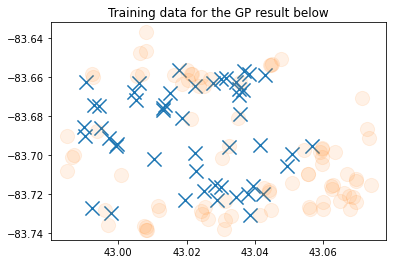

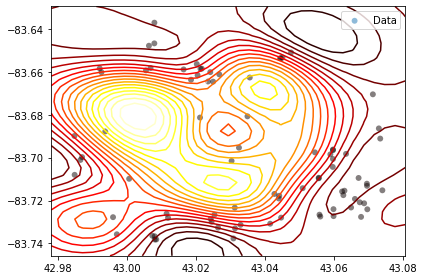

In [23]:
#fig, ax = plt.subplots(1, 2)

# plot data
dangerous_indices = [i for i in range(len(Ytrain)) if Ytrain[i]==1]
safe_indices = [i for i in range(len(Ytrain)) if Ytrain[i]==0]
plt.scatter(Xtrain[dangerous_indices,0], Xtrain[dangerous_indices,1], marker= 'x', s=200)
plt.scatter(Xtrain[safe_indices,0], Xtrain[safe_indices,1], marker= 'o', s=200, alpha=.1)
plt.title('Training data for the GP result below')

m.plot()